### Assignment for submission number 2
* Name: Ofek Biton
* ID: 209062264

In [48]:
import pandas as pd
import numpy as np
import re
import os 
import datetime
from datetime import datetime

In [49]:
file = 'matala2_cosmetics_2019-Nov.csv'
data = pd.read_csv(file)
data = data[150000:300000].drop(['brand','category_code','category_id'], axis=1)
data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5036\3793598385.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


,event_time,event_type,product_id,price,user_id,user_session
150000,2019-11-02 10:17:39 UTC,cart,5799927,4.76,526262945,0b18709b-a85d-49fc-bddd-7839caca0e1e
150001,2019-11-02 10:17:40 UTC,view,5561010,3.0,530802330,4984390a-71e0-4764-aa5b-b010a4e5c0bf
150002,2019-11-02 10:17:40 UTC,cart,5840120,1.49,492176949,dc4ba4a9-ff7d-44eb-bb7c-7e590d3d2f4f
150003,2019-11-02 10:17:41 UTC,remove_from_cart,5703538,3.89,543217561,58c6fa62-b959-4de7-b2df-d6f82e4c359a
150004,2019-11-02 10:17:41 UTC,cart,5731403,6.35,552323543,5727b7c2-8081-4c22-957b-6708067c3511


### Question 1:

In [50]:
df_q1 = data.copy()
df_q1['event_date'] = df_q1['event_time'].apply(lambda x: datetime.strptime(x.split(' ')[0], '%Y-%m-%d'))
df_q1['event_time'] = pd.to_datetime(Data['event_time'])
df_q1 = df_q1.sort_values(['user_id', 'user_session', 'event_time'])
grouped = df_q1.groupby(['user_id', 'user_session'])
df_q1['duration_to_next_event'] = grouped['event_time'].diff(periods=-1).dt.total_seconds()
df_q1['duration_to_next_event'] = abs(df_q1['duration_to_next_event'])
last_events = grouped.tail(1).index
df_q1.loc[last_events, 'duration_to_next_event'] = 0
df_q1.head()

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event
205568,2019-11-02 18:37:43+00:00,view,5823769,2.38,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,2019-11-02,0.0
169463,2019-11-02 13:19:45+00:00,view,5739901,3.49,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,2019-11-02,142.0
169727,2019-11-02 13:22:07+00:00,view,9823,3.41,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,2019-11-02,0.0
169754,2019-11-02 13:22:24+00:00,view,5854288,40.48,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,2019-11-02,0.0
172971,2019-11-02 13:52:38+00:00,view,5854829,5.24,31272873,00a50bee-4ca5-4448-9218-11b4788acd04,2019-11-02,0.0


### Question 2:

In [51]:
df_q2 = data.copy()
df_q2= df_q2.sort_values(['user_id','event_time'])
df_q2['event_time'] = pd.to_datetime(df_q2['event_time'])
df_q2['duration_from_prev_event'] = (df_q2['event_time']-df_q2['event_time'].shift(1)).dt.total_seconds()
df_q2['prev_user']=df_q2['user_id'].shift(1)
df_q2['duration_from_prev_event'] = df_q2.apply(lambda row: row.duration_from_prev_event if row.user_id== row.prev_user else 0, axis=1)
df_q2['funnelhelp']= np.where(df_q2['duration_from_prev_event'] >(5*24*60*60) ,1,0)
df_q2['funnel_number'] = df_q2.groupby('user_id')['funnelhelp'].cumsum() +1
df_q2= df_q2.drop(columns=['duration_from_prev_event','prev_user','funnelhelp'], axis=0)
df_q2.head()

,event_time,event_type,product_id,price,user_id,user_session,funnel_number
205568,2019-11-02 18:37:43+00:00,view,5823769,2.38,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1
169463,2019-11-02 13:19:45+00:00,view,5739901,3.49,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1
169727,2019-11-02 13:22:07+00:00,view,9823,3.41,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1
169754,2019-11-02 13:22:24+00:00,view,5854288,40.48,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1
170998,2019-11-02 13:32:53+00:00,view,5757575,4.27,31272873,168527dd-ae0c-45f7-b524-01b492269456,1


### Question 3:

In [52]:
df_q3 = df_q2.copy()
df_q3.sort_values(['funnel_number','user_id', 'user_session'], inplace=True)
df_q3['index_in_funnel'] = df_q3.groupby(['user_id','funnel_number'])['user_session'].transform(lambda x: x.ne(x.shift()).cumsum())
df_q3.head(20)

,event_time,event_type,product_id,price,user_id,user_session,funnel_number,index_in_funnel
205568,2019-11-02 18:37:43+00:00,view,5823769,2.38,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1
169463,2019-11-02 13:19:45+00:00,view,5739901,3.49,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1
169727,2019-11-02 13:22:07+00:00,view,9823,3.41,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1
169754,2019-11-02 13:22:24+00:00,view,5854288,40.48,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1
172971,2019-11-02 13:52:38+00:00,view,5854829,5.24,31272873,00a50bee-4ca5-4448-9218-11b4788acd04,1,1
171277,2019-11-02 13:35:53+00:00,view,5899832,3.97,31272873,0ab8eaad-f9d2-48c2-8c00-e848be49ad5a,1,2
172960,2019-11-02 13:52:31+00:00,view,5838938,4.44,31272873,13cc5be1-2afb-4632-b485-9716cc1fd3f8,1,3
173937,2019-11-02 14:01:36+00:00,view,5838938,4.44,31272873,13cc5be1-2afb-4632-b485-9716cc1fd3f8,1,3
170998,2019-11-02 13:32:53+00:00,view,5757575,4.27,31272873,168527dd-ae0c-45f7-b524-01b492269456,1,4
173733,2019-11-02 13:59:36+00:00,view,5742717,1.9,31272873,1c10c1c4-d1a0-445e-bd0c-233cc17ed396,1,5


### Question 4:

In [53]:
df_q4 = df_q3.copy()
df_q4['price'] = df_q4['price'].astype(str).apply(lambda x: re.sub('[^\d\.]', '', x)).astype(float)
df_q4.head(20)

,event_time,event_type,product_id,price,user_id,user_session,funnel_number,index_in_funnel
205568,2019-11-02 18:37:43+00:00,view,5823769,2.38,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1
169463,2019-11-02 13:19:45+00:00,view,5739901,3.49,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1
169727,2019-11-02 13:22:07+00:00,view,9823,3.41,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1
169754,2019-11-02 13:22:24+00:00,view,5854288,40.48,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1
172971,2019-11-02 13:52:38+00:00,view,5854829,5.24,31272873,00a50bee-4ca5-4448-9218-11b4788acd04,1,1
171277,2019-11-02 13:35:53+00:00,view,5899832,3.97,31272873,0ab8eaad-f9d2-48c2-8c00-e848be49ad5a,1,2
172960,2019-11-02 13:52:31+00:00,view,5838938,4.44,31272873,13cc5be1-2afb-4632-b485-9716cc1fd3f8,1,3
173937,2019-11-02 14:01:36+00:00,view,5838938,4.44,31272873,13cc5be1-2afb-4632-b485-9716cc1fd3f8,1,3
170998,2019-11-02 13:32:53+00:00,view,5757575,4.27,31272873,168527dd-ae0c-45f7-b524-01b492269456,1,4
173733,2019-11-02 13:59:36+00:00,view,5742717,1.90,31272873,1c10c1c4-d1a0-445e-bd0c-233cc17ed396,1,5


### Question 5:

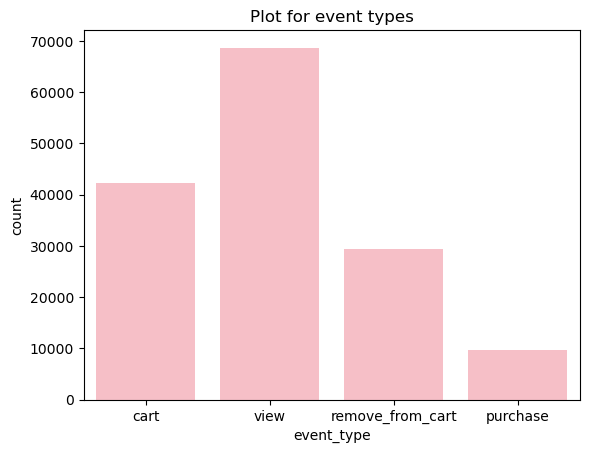

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='event_type', data=data, color = "lightpink");
plt.title('Plot for event types');

### Question 6:

#### 6e:

In [55]:
session_data= df_q4[['user_id','user_session','funnel_number','index_in_funnel']]
session_data= session_data.drop_duplicates(subset=["user_session",'funnel_number']).sort_values(['user_id'])

In [56]:
session_data['Num_of_events'] = data.groupby('user_session', sort=False)['event_type'].transform('count') 
session_data

,user_id,user_session,funnel_number,index_in_funnel,Num_of_events
205568,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1,1.0
169463,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1,2.0
169754,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1,1.0
173482,31272873,e46d97e4-9cb7-4190-9af6-7c85e0346d8a,1,15,1.0
173358,31272873,d4c06a5e-6dae-4073-921c-4153d56c822e,1,14,1.0
...,...,...,...,...,...
299936,567154755,dd4bd241-fe38-4c24-b517-5669df14a0fd,1,1,1.0
299939,567154764,42912b91-cb3a-460d-aa60-523635c94feb,1,1,1.0
299958,567154811,de93504f-8000-4d42-b3a6-864391505a76,1,1,1.0
299976,567154835,f3aa6285-d0f1-4971-947e-a400c8afb909,1,1,1.0


#### 6f:

In [57]:
session_data['total_time'] = df_q1.groupby('user_session')['duration_to_next_event'].transform('sum') 
session_data

,user_id,user_session,funnel_number,index_in_funnel,Num_of_events,total_time
205568,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1,1.0,0.0
169463,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1,2.0,142.0
169754,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1,1.0,0.0
173482,31272873,e46d97e4-9cb7-4190-9af6-7c85e0346d8a,1,15,1.0,0.0
173358,31272873,d4c06a5e-6dae-4073-921c-4153d56c822e,1,14,1.0,0.0
...,...,...,...,...,...,...
299936,567154755,dd4bd241-fe38-4c24-b517-5669df14a0fd,1,1,1.0,0.0
299939,567154764,42912b91-cb3a-460d-aa60-523635c94feb,1,1,1.0,0.0
299958,567154811,de93504f-8000-4d42-b3a6-864391505a76,1,1,1.0,0.0
299976,567154835,f3aa6285-d0f1-4971-947e-a400c8afb909,1,1,1.0,0.0


#### 6g:

In [58]:
df_q6_g = df_q4.copy()
df_q6_g = df_q6_g[df_q6_g['event_type'] == 'view']
session_data['list_of_viewed'] = df_q6_g.groupby(['user_id','user_session'])['product_id'].transform(lambda x : [x.tolist()]*len(x))
session_data

,user_id,user_session,funnel_number,index_in_funnel,Num_of_events,total_time,list_of_viewed
205568,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1,1.0,0.0,[5823769]
169463,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1,2.0,142.0,"[5739901, 9823]"
169754,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1,1.0,0.0,[5854288]
173482,31272873,e46d97e4-9cb7-4190-9af6-7c85e0346d8a,1,15,1.0,0.0,[5857277]
173358,31272873,d4c06a5e-6dae-4073-921c-4153d56c822e,1,14,1.0,0.0,[5742717]
...,...,...,...,...,...,...,...
299936,567154755,dd4bd241-fe38-4c24-b517-5669df14a0fd,1,1,1.0,0.0,[5850010]
299939,567154764,42912b91-cb3a-460d-aa60-523635c94feb,1,1,1.0,0.0,[5850001]
299958,567154811,de93504f-8000-4d42-b3a6-864391505a76,1,1,1.0,0.0,[5763379]
299976,567154835,f3aa6285-d0f1-4971-947e-a400c8afb909,1,1,1.0,0.0,[5870961]


#### 6h:

In [59]:
df_q6_h = df_q4.copy()
df_q6_h = df_q6_h[df_q6_h['event_type'] == 'cart']
session_data['list_of_added_to_cart'] = df_q6_h.groupby(['user_id','user_session'])['product_id'].transform(lambda x : [x.tolist()]*len(x))
session_data

,user_id,user_session,funnel_number,index_in_funnel,Num_of_events,total_time,list_of_viewed,list_of_added_to_cart
205568,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1,1.0,0.0,[5823769],NaN
169463,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1,2.0,142.0,"[5739901, 9823]",NaN
169754,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1,1.0,0.0,[5854288],NaN
173482,31272873,e46d97e4-9cb7-4190-9af6-7c85e0346d8a,1,15,1.0,0.0,[5857277],NaN
173358,31272873,d4c06a5e-6dae-4073-921c-4153d56c822e,1,14,1.0,0.0,[5742717],NaN
...,...,...,...,...,...,...,...,...
299936,567154755,dd4bd241-fe38-4c24-b517-5669df14a0fd,1,1,1.0,0.0,[5850010],NaN
299939,567154764,42912b91-cb3a-460d-aa60-523635c94feb,1,1,1.0,0.0,[5850001],NaN
299958,567154811,de93504f-8000-4d42-b3a6-864391505a76,1,1,1.0,0.0,[5763379],NaN
299976,567154835,f3aa6285-d0f1-4971-947e-a400c8afb909,1,1,1.0,0.0,[5870961],NaN


#### 6i:

In [60]:
df_q6_i = df_q4.copy()
df_q6_i = df_q6_i[df_q6_i['event_type'] == 'purchase']
session_data['list_of_purchased'] = df_q6_i.groupby(['user_id','user_session'])['product_id'].transform(lambda x : [x.tolist()]*len(x))
session_data

,user_id,user_session,funnel_number,index_in_funnel,Num_of_events,total_time,list_of_viewed,list_of_added_to_cart,list_of_purchased
205568,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1,1.0,0.0,[5823769],NaN,NaN
169463,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1,2.0,142.0,"[5739901, 9823]",NaN,NaN
169754,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1,1.0,0.0,[5854288],NaN,NaN
173482,31272873,e46d97e4-9cb7-4190-9af6-7c85e0346d8a,1,15,1.0,0.0,[5857277],NaN,NaN
173358,31272873,d4c06a5e-6dae-4073-921c-4153d56c822e,1,14,1.0,0.0,[5742717],NaN,NaN
...,...,...,...,...,...,...,...,...,...
299936,567154755,dd4bd241-fe38-4c24-b517-5669df14a0fd,1,1,1.0,0.0,[5850010],NaN,NaN
299939,567154764,42912b91-cb3a-460d-aa60-523635c94feb,1,1,1.0,0.0,[5850001],NaN,NaN
299958,567154811,de93504f-8000-4d42-b3a6-864391505a76,1,1,1.0,0.0,[5763379],NaN,NaN
299976,567154835,f3aa6285-d0f1-4971-947e-a400c8afb909,1,1,1.0,0.0,[5870961],NaN,NaN


In [61]:
session_data['Num_of_events'] = session_data['Num_of_events'].fillna(0.0)
session_data['total_time'] = session_data['total_time'].fillna(0.0)
session_data['list_of_viewed'] = session_data['list_of_viewed'].fillna("").apply(list)
session_data['list_of_added_to_cart'] = session_data['list_of_added_to_cart'].fillna("").apply(list)
session_data['list_of_purchased'] = session_data['list_of_purchased'].fillna("").apply(list)
session_data

,user_id,user_session,funnel_number,index_in_funnel,Num_of_events,total_time,list_of_viewed,list_of_added_to_cart,list_of_purchased
205568,22870151,27f42d5a-1c7f-4142-915d-3bda8f3dd612,1,1,1.0,0.0,[5823769],[],[]
169463,27872944,465c3a6d-8d8c-407f-bc3c-9502452f41f1,1,1,2.0,142.0,"[5739901, 9823]",[],[]
169754,28405962,363a84cb-3669-4ec2-9812-ce21d127e498,1,1,1.0,0.0,[5854288],[],[]
173482,31272873,e46d97e4-9cb7-4190-9af6-7c85e0346d8a,1,15,1.0,0.0,[5857277],[],[]
173358,31272873,d4c06a5e-6dae-4073-921c-4153d56c822e,1,14,1.0,0.0,[5742717],[],[]
...,...,...,...,...,...,...,...,...,...
299936,567154755,dd4bd241-fe38-4c24-b517-5669df14a0fd,1,1,1.0,0.0,[5850010],[],[]
299939,567154764,42912b91-cb3a-460d-aa60-523635c94feb,1,1,1.0,0.0,[5850001],[],[]
299958,567154811,de93504f-8000-4d42-b3a6-864391505a76,1,1,1.0,0.0,[5763379],[],[]
299976,567154835,f3aa6285-d0f1-4971-947e-a400c8afb909,1,1,1.0,0.0,[5870961],[],[]
